In [23]:
import rasterio
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from tqdm import tqdm
from boto3.s3.transfer import TransferConfig
import boto3
from rasterio.session import AWSSession
from pathlib import Path

# Get AWS Session

In [24]:
session = boto3.session.Session(profile_name='saml-pub')
s3 = session.resource('s3')

# Get Metadata for Hansen Tiles in GeoDataFrame

In [25]:
obj = s3.Object('calval-metadata', 'test-prod--cropped-hansen-landsat-mosaics-2020.geojson')
obj.get()

{'ResponseMetadata': {'RequestId': 'RYEQ45DQ4M858GJD',
  'HostId': 'WlvjBG4GMefRVxXUaXCmNY3PEzUCFweWLnp+BKH7e1UsPgPz/PoBlU7Yu4WTVe5xmnR2MmViB0c=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'WlvjBG4GMefRVxXUaXCmNY3PEzUCFweWLnp+BKH7e1UsPgPz/PoBlU7Yu4WTVe5xmnR2MmViB0c=',
   'x-amz-request-id': 'RYEQ45DQ4M858GJD',
   'date': 'Wed, 29 Dec 2021 19:14:24 GMT',
   'last-modified': 'Wed, 29 Dec 2021 19:11:09 GMT',
   'etag': '"9ddaa0f0935cbe8479d4216a0b156929"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '1135'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 12, 29, 19, 11, 9, tzinfo=tzutc()),
 'ContentLength': 1135,
 'ETag': '"9ddaa0f0935cbe8479d4216a0b156929"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f98fd55d5d0>}

<AxesSubplot:>

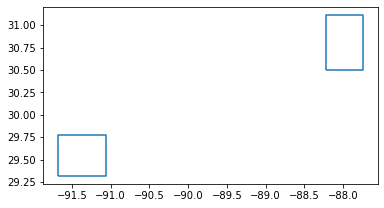

In [26]:
data = obj.get()['Body']
df_delta_tiles = gpd.read_file(data)
df_delta_tiles.exterior.plot()

In [27]:
df_delta_tiles

,bucket,key,source_url,year,geometry
0,test-prod--cropped-hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_30N_100W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-91.67827 29.32052, -91.06015 29.320..."
1,test-prod--cropped-hansen-landsat-mosaics-2020,Hansen_GFC-2020-v1.8_last_40N_090W.tif,https://storage.googleapis.com/earthenginepart...,2020,"POLYGON ((-88.21591 30.50389, -87.74982 30.503..."


In [28]:
records = df_delta_tiles.to_dict('records')

# Create a "Local" Bucket

In [29]:
out_dir = records[0]['bucket']
out_dir_path = Path(out_dir)
out_dir_path.mkdir(exist_ok=True)

# Read Data with Rasterio (Example)

It's negligible on a fast server.

The buckets have to be unique globally - interesting that this is harder than it seems and will throw an [error](https://stackoverflow.com/q/57146311) like this.

In [30]:
record = records[0]

Reference is this [issue ticket](https://github.com/rasterio/rasterio/issues/1507)

In [31]:
bucket = record['bucket']
key = record['key']

with rasterio.Env(AWSSession(session)):
    with rasterio.open(f's3://{bucket}/{key}') as ds:
        profile = ds.profile
        
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2473, 'height': 1810, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -91.6785,
       0.0, -0.00025, 29.77325), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

Reading the image cam take some time with large image. However, for smaller images this can be faster (no need to orchestrate threads).

In [36]:
%%time

bucket = record['bucket']
key = record['key']

with rasterio.Env(AWSSession(session)):
    with rasterio.open(f's3://{bucket}/{key}') as ds:
        X = ds.read()

CPU times: user 142 ms, sys: 14.7 ms, total: 156 ms
Wall time: 469 ms


For pedagogy, let's use `boto3` built in multithreading.

In [33]:
obj = s3.Object(bucket, key)
resp = obj.get()
resp

{'ResponseMetadata': {'RequestId': 'NYNJPV5AFWFGMJ6H',
  'HostId': 'mZgCIvEij9cycGXPvQMkDzNBmDw5E1ouPf/ZEpKQp9uOETas4cIoP7tGfLytXSTQKYE/KmFmhwM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'mZgCIvEij9cycGXPvQMkDzNBmDw5E1ouPf/ZEpKQp9uOETas4cIoP7tGfLytXSTQKYE/KmFmhwM=',
   'x-amz-request-id': 'NYNJPV5AFWFGMJ6H',
   'date': 'Wed, 29 Dec 2021 19:15:27 GMT',
   'last-modified': 'Wed, 29 Dec 2021 19:12:01 GMT',
   'etag': '"94f33379070b89771582d4b25658a5d9-2"',
   'accept-ranges': 'bytes',
   'content-type': 'binary/octet-stream',
   'server': 'AmazonS3',
   'content-length': '10878372'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2021, 12, 29, 19, 12, 1, tzinfo=tzutc()),
 'ContentLength': 10878372,
 'ETag': '"94f33379070b89771582d4b25658a5d9-2"',
 'ContentType': 'binary/octet-stream',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f98fd4cdb70>}

Some [notes](https://stackoverflow.com/questions/57868574/different-between-download-file-and-download-fileobj-in-boto3) about different ways to download files.

In [34]:
obj = s3.Object(bucket, key)
resp = obj.get()

total_size = resp['ContentLength']
config = TransferConfig(multipart_threshold=1024, 
                        max_concurrency=30, 
                        use_threads=True)
with tqdm(total=total_size,  
          unit='B', 
          unit_scale=True, 
          unit_divisor=1024) as pbar:

    s3.meta.client.download_file(bucket, key, str(out_dir_path / key), Config=config, Callback=pbar.update)
    

100%|████████████████████████████████████████████████| 10.4M/10.4M [00:04<00:00, 2.50MB/s]


In [37]:
%%time

with rasterio.open(f'{bucket}/{key}') as ds:
    X = ds.read()
X.shape

CPU times: user 120 ms, sys: 5.97 ms, total: 126 ms
Wall time: 123 ms


(4, 1810, 2473)

In [38]:
image = X.transpose([1, 2, 0])

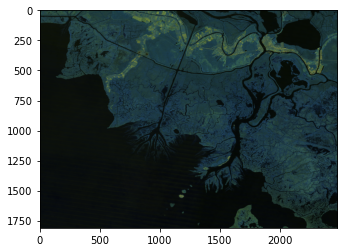

In [40]:
plt.imshow(image[:, :, [3, 2, 1]])

# Automate

In [41]:
records

[{'bucket': 'test-prod--cropped-hansen-landsat-mosaics-2020',
  'key': 'Hansen_GFC-2020-v1.8_last_30N_100W.tif',
  'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_30N_100W.tif',
  'year': 2020,
  'geometry': <shapely.geometry.polygon.Polygon at 0x7f98fc320c40>},
 {'bucket': 'test-prod--cropped-hansen-landsat-mosaics-2020',
  'key': 'Hansen_GFC-2020-v1.8_last_40N_090W.tif',
  'source_url': 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2020-v1.8/Hansen_GFC-2020-v1.8_last_40N_090W.tif',
  'year': 2020,
  'geometry': <shapely.geometry.polygon.Polygon at 0x7f98fc320f70>}]

In [42]:
def download_record_multithreading(record):
    
    
    bucket = record['bucket']
    key = record['key']

    obj = s3.Object(bucket, key)
    resp = obj.get()

    total_size = resp['ContentLength']
    config = TransferConfig(multipart_threshold=1024, 
                            max_concurrency=30, 
                            use_threads=True)
    with tqdm(total=total_size,  
              unit='B', 
              unit_scale=True, 
              unit_divisor=1024,
              desc=key) as pbar:
        out_path = out_dir_path / key
        s3.meta.client.download_file(bucket, key, str(out_path), Config=config, Callback=pbar.update)
    return out_path

In [43]:
results = list(map(download_record, records))
results

Hansen_GFC-2020-v1.8_last_30N_100W.tif: 100%|████████| 10.4M/10.4M [00:02<00:00, 5.28MB/s]
Hansen_GFC-2020-v1.8_last_40N_090W.tif: 100%|████████| 13.0M/13.0M [00:00<00:00, 16.8MB/s]


[PosixPath('test-prod--cropped-hansen-landsat-mosaics-2020/Hansen_GFC-2020-v1.8_last_30N_100W.tif'),
 PosixPath('test-prod--cropped-hansen-landsat-mosaics-2020/Hansen_GFC-2020-v1.8_last_40N_090W.tif')]

# Verify Tiles Match with Image

In [44]:
from shapely.geometry import box, Polygon
from rasterio.crs import CRS

def get_extents_bbox(path: Path) -> Polygon:
    with rasterio.open(path) as ds:
        bounds = list(ds.bounds)
    return box(*bounds)

geometry = list(map(get_extents_bbox, results))

df_extent_tifs = gpd.GeoDataFrame(geometry=geometry, crs=CRS.from_epsg(4326))

<AxesSubplot:>

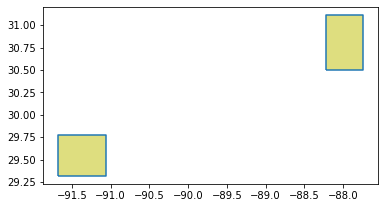

In [45]:
fig, ax = plt.subplots()

df_extent_tifs.plot(ax=ax, alpha=.5, color='y')
df_delta_tiles.exterior.plot(ax=ax)